In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql.types import TimestampType
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
plt.rc("axes", axisbelow=True)

import os

spark = SparkSession.builder.getOrCreate()

22/08/18 09:13:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Preparing datasets

In [2]:
#  Reading csv file
olist_orders_dataset = spark.read.options(header='True', inferSchema='True', delimiter=',') \
                            .csv("/home/jovyan/work/sales_analysis/data/olist_orders_dataset.csv")
# olist_orders_dataset = spark.read.options(header='True', inferSchema='True', delimiter=',') \
#                             .csv("ecommerce_data/olist_orders_dataset.csv")

In [3]:
# orders_date - dataframe with order id, its estimated delivery date and date of receipt of the order by the customer
orders_date = olist_orders_dataset.select("order_id","order_estimated_delivery_date","order_delivered_customer_date")
orders_date = orders_date.withColumn('order_estimated_delivery_date',to_date(unix_timestamp \
            (orders_date.order_estimated_delivery_date, 'yyyy-MM-dd HH:mm:ss').cast('timestamp'))) \
                        .withColumn('order_delivered_customer_date',to_date(unix_timestamp \
            (orders_date.order_delivered_customer_date, 'yyyy-MM-dd HH:mm:ss').cast('timestamp')))

# delayed_orders - subset of orders_date (orders that took longer to deliver than estimated time)
delayed_orders = orders_date.select("order_id","order_estimated_delivery_date","order_delivered_customer_date") \
            .filter(orders_date.order_estimated_delivery_date < orders_date.order_delivered_customer_date)

# delayed_days - dataframe with information about the amount of orders delayed by n days
delayed_orders.createOrReplaceTempView("delayed_orders")
delayed_days = spark.sql("""
    SELECT days_delayed, COUNT(*) as no_orders FROM
        (SELECT order_id, DATEDIFF(order_delivered_customer_date, order_estimated_delivery_date) days_delayed FROM delayed_orders)
        GROUP BY days_delayed
        ORDER BY days_delayed
    ;
""")

# orders_days_delayed - dataframe with deleyed orders_id and number of days by wich each order was delayed

orders_days_delayed = spark.sql("""
    SELECT order_id, DATEDIFF(order_delivered_customer_date, order_estimated_delivery_date) days_delayed FROM delayed_orders;
""")

## Basic statistics

In [4]:
orders_count = orders_date.count()
delayed_orders_count = delayed_orders.count()
undelivered_orders_count = orders_date.where(F.col('order_delivered_customer_date').isNull()).count()
print(f"All orders: {orders_count}")
print(f"Delayed orders: {delayed_orders_count} ({delayed_orders_count / orders_count * 100:.1f}% of all orders)")
print(f"Undelivered orders: {undelivered_orders_count} ({undelivered_orders_count / orders_count * 100:.1f}% of all orders)")

All orders: 99441
Delayed orders: 6535 (6.6% of all orders)
Undelivered orders: 2965 (3.0% of all orders)


### Saving dataframes to parquet

In [5]:
delayed_days.write.parquet("/home/jovyan/work/sales_analysis/raport/transformed_data/1_task_days_delayed.parquet",mode="overwrite")
orders_days_delayed.describe(("days_delayed")).write.parquet("/home/jovyan/work/sales_analysis/raport/transformed_data/1_task_days_delayed_basic_statistics.parquet",mode="overwrite")
orders_dataframe = spark.createDataFrame([
    Row(order_type="Delivered", count=orders_count - delayed_orders_count - undelivered_orders_count),
    Row(order_type="Delayed", count=delayed_orders_count),
    Row(order_type="Undelivered", count=undelivered_orders_count)
])
orders_dataframe.write.parquet("/home/jovyan/work/sales_analysis/raport/transformed_data/1_task_orders_structure.parquet",mode="overwrite")

In [6]:
orders_days_delayed.describe(("days_delayed")).show()
orders_days_delayed.where(orders_days_delayed["days_delayed"]==188).count()

+-------+------------------+
|summary|      days_delayed|
+-------+------------------+
|  count|              6535|
|   mean|  10.6203519510329|
| stddev|14.643843860910607|
|    min|                 1|
|    max|               188|
+-------+------------------+



1

### The most delayed order: 188 days
### Average delay of an order: 10.62 days
### Standard deviation of delayed orders: 14.64 days

### Null values in  "order_delivered_customer_date" column we treat as not delivered orders

In [7]:
# Checking missing values
print(f"Null values in column order_id: {orders_date.where(F.col('order_id').isNull()).count()}")
print(f"Null values in column order_estimated_delivery_date: {orders_date.where(F.col('order_estimated_delivery_date').isNull()).count()}")
print(f"Null values in column order_delivered_customer_date: {undelivered_orders_count}")

Null values in column order_id: 0
Null values in column order_estimated_delivery_date: 0
Null values in column order_delivered_customer_date: 2965


### Make a schedule chart for all & delayed orders

In [8]:
#  preparing directory for plots
try:
    os.mkdir("plots")
except OSError as error:
    pass

In [9]:
print(f"Number of undelivered & delayed orders: {orders_date.where(F.col('order_delivered_customer_date').isNull()).count()+delayed_orders.count()}")
print(f"Percent of undelivered & delayed orders: {(orders_date.where(F.col('order_delivered_customer_date').isNull()).count()+delayed_orders.count())/orders_date.count()*100}")

Number of undelivered & delayed orders: 9500
Percent of undelivered & delayed orders: 9.553403525708712


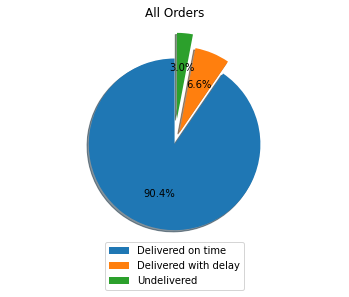

In [10]:
explode = (0, .15, .3)

labels_d = "Delivered on time", "Delivered with delay", "Undelivered"
data_d = [
    orders_date.count() - (undelivered_orders_count + delayed_orders_count),
    delayed_orders_count,
    undelivered_orders_count 
]

fig, ax = plt.subplots()
ax.pie(data_d, explode=explode, labels=None, autopct="%1.1f%%", shadow=True, startangle=90)
ax.axis("equal")

plt.title("All Orders")
plt.legend(labels_d, loc="lower center", bbox_to_anchor=(0.5, -.25))
plt.savefig("plots/task_1_pie_chart.pdf", bbox_inches="tight")
plt.savefig("plots/task_1_pie_chart.png", dpi=200, bbox_inches="tight")
plt.show()


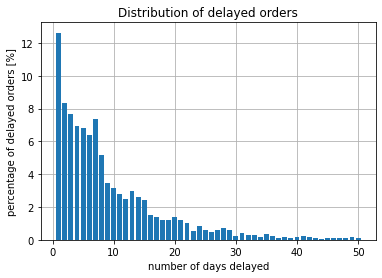

In [11]:
x = delayed_days.select("days_delayed").rdd.flatMap(lambda _: _).collect()
y = delayed_days.select("no_orders").rdd.flatMap(lambda _: _).collect()

plt.grid(which="both")
plt.bar(x[:50], [100 * i / delayed_orders_count for i in y[:50]])
plt.title("Distribution of delayed orders")
plt.xlabel("number of days delayed")
plt.ylabel("percentage of delayed orders [%]")

plt.savefig("plots/task_1_distribution_of_delayed_orders.pdf", bbox_inches="tight")
plt.savefig("plots/task_1_distribution_of_delayed_orders.png", dpi=300, bbox_inches="tight")
plt.show()
